# 3 ML Model Predictions

# Imports & Functions

## Imports

In [7]:
# General imports
import os
import sys
import gc
import warnings
from typing import Literal

from datetime import datetime
from pprint import pprint
import time
import pickle
import cloudpickle
import joblib
import random
from collections import Counter

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# ML Prep
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector

# ML Training
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Run. 1 Study Load & Model

In [14]:
#---- Parameters --------------------------------
# Study & Processing Run Details
study_name = 'IOWA_Rest'
eeg_features_run = '1b_EEG_Features_Results_Run_20250801_full_run'
ml_training_run = '2a_Feature_Extraction_Data_Run_20250802_extract_train_RF'

run_description = 'test_prediction'
test_mode = True

#----------------------------------------------------

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# EEG Processing Results Data
eeg_features_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_features_run)
eeg_features_run_details = pd.read_pickle(eeg_features_run_results_path + '/run_details.pkl', compression='zip')
eeg_preprocessing_run = eeg_features_run_details['eeg_preprocessed_data']

eeg_preprocessing_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_preprocessing_run)
eeg_preprocessed_data_path = utils.get_folder_path(eeg_preprocessing_run_results_path + '/Cleaned_files' )
eeg_preprocessing_run_details = pd.read_pickle(eeg_preprocessing_run_results_path + '/run_details.pkl', compression='zip')
eeg_processing_results_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_processing_results_df.pkl', compression='zip')
eeg_features_superset_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_superset_df.pkl', compression='zip')
eeg_features_flattened_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_flattened_df.pkl', compression='zip')
 
# Feature Selection, Preparation and ML Model
ml_training_run_results_path = utils.get_folder_path(study_info['ml_training_results_path'] + '/' + ml_training_run)
ml_training_run_details = pd.read_pickle(ml_training_run_results_path + '/run_details.pkl', compression='zip')

features_prep_pipeline = pickle.load(open(ml_training_run_results_path + '/' + 'features_prep_pipeline.pkl', 'rb'))
grid_search = pickle.load(open(ml_training_run_results_path + '/' + 'grid_search.pkl', 'rb'))
model_randforest = pickle.load(open(ml_training_run_results_path + '/' + 'model_randforest.pkl', 'rb'))




In [5]:
# Processing Run Details & Data Structures
summary = f'EEG Processing Parameters'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- EEG Processing Run: {eeg_preprocessing_run_details['run_name']}"
summary = summary + f"\n-   Preprocess Params: {eeg_preprocessing_run_details['preprocess_params']}"
summary = summary + f"\n-   ICA Params: {eeg_preprocessing_run_details['artefact_params']}"
summary = summary + f"\n- EEG Features Run: {eeg_features_run}"
summary = summary + f"\n-   PSD Params: {eeg_features_run_details['psd_params']}"
summary = summary + f"\n-   SpecParam Params: {eeg_features_run_details['specparam_params']}"
summary = summary + f"\n- Features Extraction / ML Training Run: {ml_training_run}"
summary = summary + f"\n-   Feature Extraction Params: {ml_training_run_details['extraction_params']}"
print(f'{summary}\n')



EEG Processing Parameters
- Study: IOWA_Rest ds004584-1.0.0
- EEG Processing Run: 1a_EEG_Preprocessing_Run_20250724_full_ica
-   Preprocess Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': 'linear', 'channel_referencing': 'average'}
-   ICA Params: {'ica_method': 'infomax', 'ICA_rejection_threshold': 0.8}
- EEG Features Run: 1b_EEG_Features_Results_Run_20250801_full_run
-   PSD Params: {'method': 'welch', 'fmin': 1, 'fmax': 100, 'exclude': []}
-   SpecParam Params: {'peak_width_limits': [1, 12], 'max_n_peaks': 6, 'min_peak_height': 0.1, 'peak_threshold': 2.0, 'aperiodic_mode': 'fixed', 'fit_window': [2, 40], 'fit_error_threshold': 0.1, 'fit_r2_threshold': 0.9}
- Features Extraction / ML Training Run: 2a_Feature_Extraction_Data_Run_20250802_extract_train_RF
-   Feature Extraction Params: {'features_detail_level': 'region', 'subject_meta_include': False, 'aperiodic_include': False, 'periodic_include': True}



## Run Features Prep & Model Predictions

In [32]:
target_col_name = 'pd'
feature_names = eeg_features_flattened_df.columns[eeg_features_flattened_df.columns != target_col_name]
X = eeg_features_flattened_df[feature_names].copy()
y = eeg_features_flattened_df[target_col_name].copy()

X_transformed = features_prep_pipeline.transform(X)

In [33]:
# Check the full pipeline structure
print("Feature Extraction Pipeline Steps:")
for name, step in features_prep_pipeline.named_steps.items():
    print(f"- {name}: {step}")

print("\nColumnTransformer Details:")
ct = features_prep_pipeline.named_steps['data_preprocess']
for name, trans, cols in ct.transformers_:
    print(f"- Transformer: {name}")
    print(f"    Columns: {cols}")
    print(f"    Transformer object: {trans}\n")

Feature Extraction Pipeline Steps:
- features_selection: FeatureSelection(features_detail_level='region',
                 selected_features=['pw', 'bw', 'cf'])
- data_preprocess: ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scale_num',
                                                  RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17c961610>),
                                ('categorical',
                                 Pipeline(steps=[('encode_cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'))]),
       

In [34]:
# Check the pipeline structure
print("Pipeline transformers:")
# Access the ColumnTransformer from within the loaded pipeline
cols_transform = features_prep_pipeline.named_steps['data_preprocess']
for name, transformer, columns in cols_transform.transformers_:
    print(f"- {name}: {len(columns) if hasattr(columns, '__len__') else 'Unknown'} columns")

Pipeline transformers:
- numeric: 54 columns
- categorical: 0 columns


In [35]:
# Checkpoint - Transformation Results

# TODO: Examine the impact of scaling etc more closely eg some boxplots before and after .... how well has eg scaling worked?

# Before & After
print("Features Extraction / Transformed Data")
print(f'- Original Features Selection: {eeg_features_flattened_df.shape}')
print(f'- Original X: {X.shape} and y: {y.shape}')
print(f'- Transformed X: {X_transformed.shape}')
print(f'- Num feature names from pipeline: {len(cols_transform.get_feature_names_out())}')

# Feature Names
# print("\nFeature Names")
# print("Numerical:", len(numerical_cols), numerical_cols[:5] if numerical_cols else "None")
# print("Categorical:", len(categorical_cols), categorical_cols[:5] if categorical_cols else "None")

print("\nTransformed")
temp_names_X_train_df = pd.DataFrame(X_transformed, columns=cols_transform.get_feature_names_out())
temp_names_X_train_df.reset_index(drop=True, inplace=True)
# print(list(temp_names_X_train_df.columns[:]))
# print("\nHead of X_train_transformed:")
display(temp_names_X_train_df.head())

# Check the pipeline structure
print("Pipeline transformers:")
for name, transformer, columns in cols_transform.transformers_:
    print(f"- {name}: {len(columns) if hasattr(columns, '__len__') else 'Unknown'} columns")


Features Extraction / Transformed Data
- Original Features Selection: (149, 1478)
- Original X: (149, 1477) and y: (149,)
- Transformed X: (149, 54)
- Num feature names from pipeline: 54

Transformed


,numeric__region_frontal_cf_0,numeric__region_frontal_pw_0,numeric__region_frontal_bw_0,numeric__region_frontal_cf_1,numeric__region_frontal_pw_1,numeric__region_frontal_bw_1,numeric__region_frontal_cf_2,numeric__region_frontal_pw_2,numeric__region_frontal_bw_2,numeric__region_frontal_cf_3,...,numeric__region_posterior_bw_2,numeric__region_posterior_cf_3,numeric__region_posterior_pw_3,numeric__region_posterior_bw_3,numeric__region_posterior_cf_4,numeric__region_posterior_pw_4,numeric__region_posterior_bw_4,numeric__region_posterior_cf_5,numeric__region_posterior_pw_5,numeric__region_posterior_bw_5
0,-0.745928,-0.440751,0.508586,0.856898,0.091707,0.805519,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.080383,-0.057352,-0.605198,0.195960,-0.222267,0.270533,1.026144,0.184626,0.500324,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.089113,0.571213,6.325786,-0.947296,-0.588557,-0.618583,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.155663,0.393724,0.781373,-0.947296,-0.588557,-0.618583,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.977729,-0.345230,-0.650683,-0.011435,0.465785,-0.260010,0.977247,1.030619,0.648500,0.0,...,1.018141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Pipeline transformers:
- numeric: 54 columns
- categorical: 0 columns


In [31]:
print("Grid Search:")
print(grid_search)

print(f'Best parameters: \n{grid_search.best_params_}')
print("Best cross-validation score:", grid_search.best_score_)

Grid Search:
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42,
                                                               verbose=False))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [2, 10, None],
                         'classifier__max_leaf_nodes': [50, None],
                         'classifier__n_estimators': [150, 175]},
             scoring='precision')
Best parameters: 
{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_leaf_nodes': 50, 'classifier__n_estimators': 150}
Best cross-validation score: 0.7597035369171592


In [36]:
# Checkpoint - ML Pipeline

print("ML Model Pipeline Steps:")
for name, step in model_randforest.named_steps.items():
    print(f"- {name}: {step}")

print("\nAll Pipeline Parameters")
for param, value in model_randforest.get_params().items():
    print(f"- {param}: {value}")

ML Model Pipeline Steps:
- classifier: RandomForestClassifier(max_depth=10, max_leaf_nodes=50, n_estimators=150,
                       n_jobs=-1, random_state=42, verbose=False)

All Pipeline Parameters
- memory: None
- steps: [('classifier', RandomForestClassifier(max_depth=10, max_leaf_nodes=50, n_estimators=150,
                       n_jobs=-1, random_state=42, verbose=False))]
- transform_input: None
- verbose: False
- classifier: RandomForestClassifier(max_depth=10, max_leaf_nodes=50, n_estimators=150,
                       n_jobs=-1, random_state=42, verbose=False)
- classifier__bootstrap: True
- classifier__ccp_alpha: 0.0
- classifier__class_weight: None
- classifier__criterion: gini
- classifier__max_depth: 10
- classifier__max_features: sqrt
- classifier__max_leaf_nodes: 50
- classifier__max_samples: None
- classifier__min_impurity_decrease: 0.0
- classifier__min_samples_leaf: 1
- classifier__min_samples_split: 2
- classifier__min_weight_fraction_leaf: 0.0
- classifier__mon

Accuracy: 0.9530
Precision: 0.9346
Recall: 1.0000
F1 Score 0.9662
Specificity: 0.8571
Hamming Loss 0.0470
Fall Out (FPR): 0.1429
ROC-AUC Score 0.9951
Gini Index: 0.9902


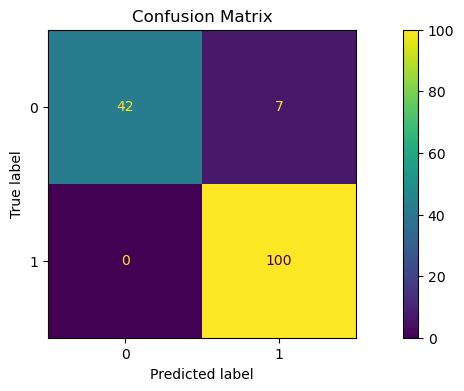

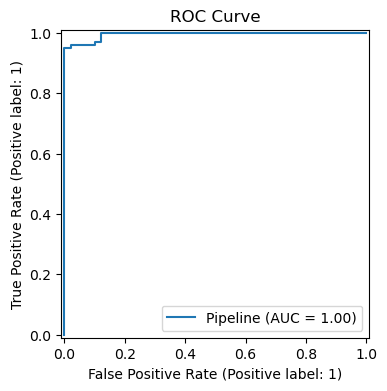

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_leaf_nodes': 50, 'classifier__n_estimators': 150}
Best cross-validation score: 0.7597035369171592
Importance
(54, 2)


,Feature,Importance
36,numeric__region_posterior_cf_0,0.092721
0,numeric__region_frontal_cf_0,0.075063
18,numeric__region_central_cf_0,0.058811
3,numeric__region_frontal_cf_1,0.057006
1,numeric__region_frontal_pw_0,0.054019


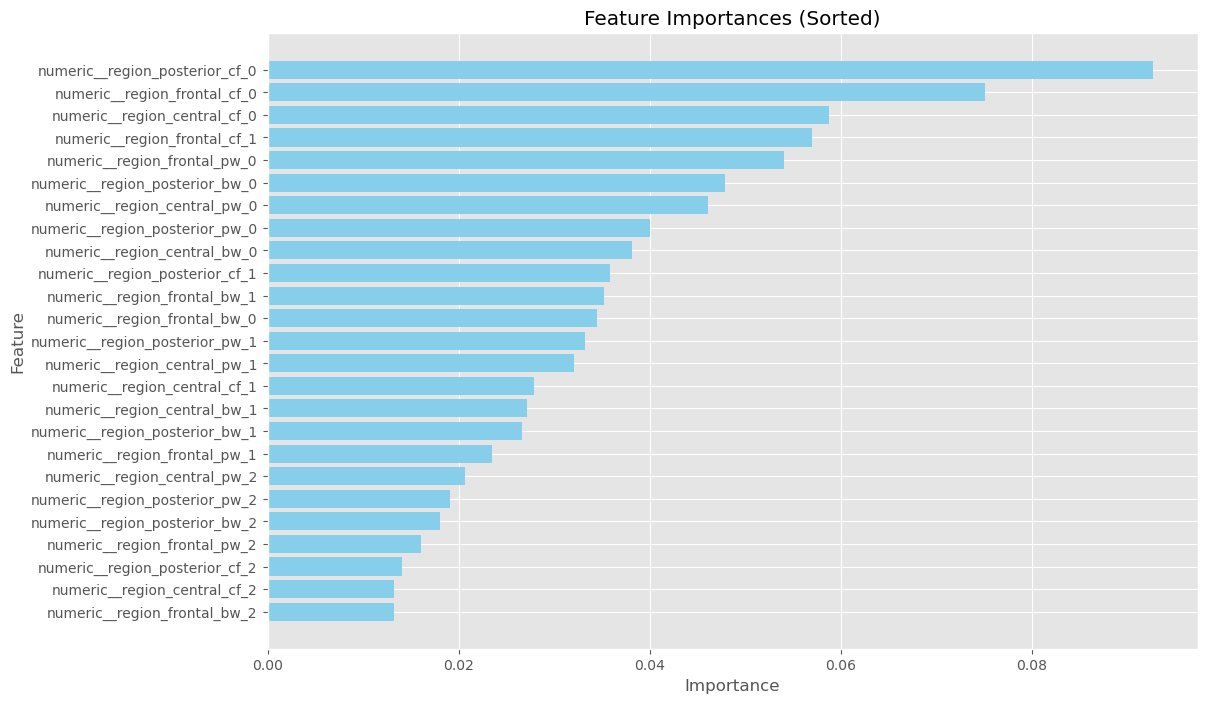

In [41]:
# Model Predictions

y_pred = model_randforest.predict(X_transformed)

# Evaluate Prediction Results
classification_metrics(model_randforest, X_transformed, y, y_pred)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Contribution / Importance
plot_feature_importance(model_randforest)

In [37]:
# Function to Display The Model Fit Results

def print_search_results(search, duration):
    print('------- Search Results --------')
    all_search_results = pd.DataFrame(search.cv_results_)
    print(f"Score: {search.best_score_:.4f}. Mean: {np.mean(all_search_results['mean_test_score']):.4f} and STD {np.std(all_search_results['mean_test_score']):.4f}")
    print(f'Search Took: {duration:.2f} seconds')
    print(f"Best Parameters: {search.best_params_}")
    
    top_n = 10
    print(f"Top {top_n} out of {len(all_search_results)} combinations:")
    display(all_search_results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']].sort_values(by='rank_test_score').head(top_n))


In [38]:
# Function to Present the Evaluation Metrics for a Classification Model

def classification_metrics(for_Model, X_test, y_test, y_pred):
    plt.style.use('default')

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print various metrics
    print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Precision: {metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'Recall: {metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'F1 Score {metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'Specificity: {tn / (tn + fp):.4f}')
    print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Fall Out (FPR): {fp / (fp + tn):.4f}')


    # Plot Confusion Matrix
    class_labels = for_Model.classes_
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax)
    plt.show

    y_probabilities = for_Model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probabilities)
    print(f'ROC-AUC Score {roc_auc_score:.4f}')
    gini_score = 2 * roc_auc_score - 1
    print(f'Gini Index: {gini_score:.4f}')

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve')
    roc_display = RocCurveDisplay.from_estimator(for_Model, X_test, y_test, ax=ax, pos_label=1)
    plt.show()

    plt.style.use('ggplot')

In [40]:
# Get Feature Importance for a RandomForest

def plot_feature_importance(model_rf):

    # Get feature importances
    importances = model_rf.named_steps['classifier'].feature_importances_

    # Map feature importances to transformed feature names
    transformed_feature_names = cols_transform.get_feature_names_out()
    importance_df = pd.DataFrame({
        'Feature': transformed_feature_names,
        'Importance': importances
        }).sort_values(by='Importance', ascending=False)
    
    # Importance
    print('Importance')
    print(importance_df.shape)
    display(importance_df.head())
    
    # Keep only the top 25 most important features & plot
    importance_df = importance_df.head(25)

    # Plot the feature importances with names horizontally
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances (Sorted)')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()